In [2]:
import sympy as sym
import mpmath
import numpy as np
import matplotlib.pyplot as plt

# Symbolic Integration

the classical "pen and paper" way to calculate the integral

### indefinite integral(antiderivative)

Given $F' = f$, where $F$ is the antiderivative of $f$

- Remark : $\int_{a}^{b} f(x) \mathrm{d} x = F(b) - F(a)$

e.g. $\sin(x)$ is the antiderivative of $\cos(x)$

In [5]:
x = sym.symbols('x')
sym.integrate(sym.cos(x), x)

sin(x)

### definite integral

$$F = \int_{a}^{b} f(x) \mathrm{d} x,$$ 
where $F$ is the definite integral, $a$ is lower limit, $b$ is upper limit, and $x$ is the integration variable.

e.g. $\int_{-\frac{\pi}{2}}^{\frac{\pi}{2}} \cos(x) \mathrm{d} x$

In [8]:
sym.integrate(sym.cos(x), (x,-sym.pi/2,sym.pi/2))

2

In [9]:
# verify by antiderivative
a, b = sym.symbols('a b')
expr = sym.sin(b) - sym.sin(a)
expr.subs([(a, -sym.pi/2), (b, sym.pi/2)])

2

# Linear Approximation

approximate $f(x) = 10(x-1)^2 - 1, x\in[1,2]$ by $u(x) \in V$, where $V=\text{span} \{1, x\}$. Specifically, $u(x) = c_0 \psi_0(x) + c_1 \psi_1(x)$, where $\psi_0(x) = 1$ and $\psi_1(x)=x$.

## Least square method 

- express $u(x) = \sum_{i=0}^{N} c_i \psi_i(x)$, where $N$ is the number of basis functions
- solve $\{c_i\}_{i=0}^{N}$ by minimizing $E = \|f-u\|^2 = (f-u, f-u)$ through setting $\frac{\partial E}{\partial c_i} = 0$

Finally we get following

$$ \sum_{j=0}^{N}c_i(\psi_j, \psi_i) = (f, \psi_i)$$

if we denotes $A_{i,j}=(\psi_i, \psi_j)$, and $b_i=(f, \psi_i)$, then we get the following linear system

$$
\begin{bmatrix}
A_{0,0} & \cdots & A_{0,N} \\
\vdots & \ddots & \vdots \\
A_{N,0} & \cdots & A_{N,N} \\
\end{bmatrix} 
\begin{bmatrix}
c_{0} \\
\vdots \\
c_{N} \\
\end{bmatrix} = 
\begin{bmatrix}
b_{0} \\
\vdots \\
b_{N} \\
\end{bmatrix}
$$

In [12]:
def least_squares_symbolic(f, psi, Omega):
    N = len(psi)
    A = sym.zeros(N, N)
    b = sym.zeros(N, 1)
    x = sym.Symbol('x')

    # construct A, b
    # ! the loop below can be optimized, since A[i,j] = A[j,i]
    for i in range(N):
        for j in range(N):
            A[i,j] = sym.integrate(psi[i]*psi[j], (x, Omega[0], Omega[1]))
        b[i,0] = sym.integrate(psi[i]*f, (x, Omega[0], Omega[1]))

    # solve Ac = b
    c = A.LUsolve(b)
    u = 0
    for i in range(N):
        u += c[i,0]*psi[i]
    return u, c

In [13]:
x = sym.Symbol('x')
f = 10*(x-1)**2 - 1
u_sym, c = least_squares_symbolic(f=f, psi=[1,x,x**2], Omega=[1,2])
print("f : ", sym.expand(f))
print("u : ", u_sym)

f :  10*x**2 - 20*x + 9
u :  10*x**2 - 20*x + 9


In [14]:
def least_squares_numeric(f, psi, Omega):
    N = len(psi)
    A = sym.zeros(N, N)
    b = sym.zeros(N, 1)
    x = sym.Symbol('x')

    # construct A, b
    # ! the loop below can be optimized, since A[i,j] = A[j,i]
    for i in range(N):
        for j in range(N):
            integrate = sym.lambdify(x, psi[i]*psi[j], 'mpmath')
            A[i,j] = mpmath.quad(integrate, [Omega[0], Omega[1]])

        integrate = sym.lambdify(x, psi[i]*f, 'mpmath')
        b[i,0] =  mpmath.quad(integrate, [Omega[0], Omega[1]])

    # solve Ac = b
    c = mpmath.lu_solve(A,b)
    u = 0
    for i in range(N):
        u += c[i,0]*psi[i]
    return u, c

In [15]:
x = sym.Symbol('x')
f = 10*(x-1)**2 - 1
u_num, c = least_squares_numeric(f=f, psi=[1,x,x**2], Omega=[1,2])
print("f : ", sym.expand(f))
print("u : ", u_num)

f :  10*x**2 - 20*x + 9
u :  9.99999999999748*x**2 - 19.9999999999924*x + 8.99999999999446


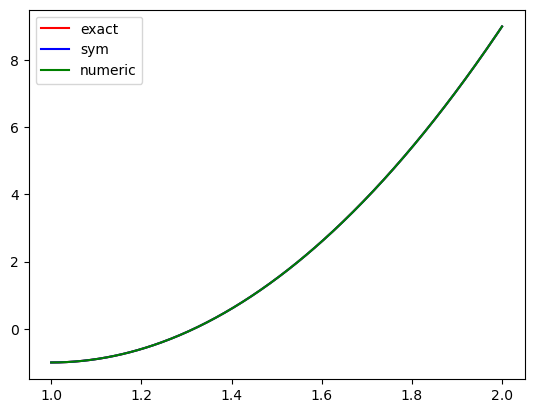

In [16]:
# visualize the result
x = sym.Symbol('x')
f = sym.lambdify(x, f, 'numpy')
u_sym = sym.lambdify(x, u_sym, modules='numpy')
u_num = sym.lambdify(x, u_num, modules='numpy')

resolution = 401
Omega = [1, 2]
xcoor = np.linspace(Omega[0], Omega[1], resolution)
exact = f(xcoor)
approx_sym = u_sym(xcoor)
approx_num = u_num(xcoor)

plt.plot(xcoor, exact, '-r', label='exact')
plt.plot(xcoor, approx_sym, '-b', label='sym')
plt.plot(xcoor, approx_num, '-g', label='numeric')
plt.legend()